# Optimization Techniques in Machine Learning

* Project name : Khelem




# Case Study and Implementation




In [122]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn for data splitting, classical ML models, and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import pickle  # For saving and loading models

# TensorFlow and Keras for building neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# The Dataset
> ***Brief Description:***
The goal of this project is to develop and compare machine learning models to classify health outcomes based on various health indicators. By leveraging both classical algorithms (such as Logistic Regression) and neural network approaches (with and without optimization techniques), the project aims to determine the most effective method for accurately predicting the target outcome. This includes exploring different optimization strategies—like regularization, early stopping, and hyperparameter tuning—to enhance model performance and convergence speed.

Data Description:
The dataset, referred to as "Khelem," contains a range of health indicators sourced from Burkina Faso. It includes several features that represent various health metrics essential for assessing overall health status. The target variable is binary, indicating a specific health outcome to be predicted. This dataset provides a practical real-world scenario for testing classification models and applying optimization techniques within machine learning.


In [123]:
import pandas as pd

# Load the dataset "Khelem"
df = pd.read_csv("health_indicators_bfa.csv")

# Display the first few rows to verify the data
print(df.head())

# Get dataset info (data types, non-null counts, etc.)
print(df.info())

# Get descriptive statistics for numerical features
print(df.describe())

# Check for missing values in each column
print(df.isnull().sum())


             GHO (CODE)                                      GHO (DISPLAY)  \
0       #indicator+code                                    #indicator+name   
1           NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   
2  WSH_SANITATION_BASIC  Population using at least basic sanitation ser...   
3       NCD_BMI_MINUS2C  Prevalence of thinness among children and adol...   
4   GHED_CHEGDP_SHA2011  Current health expenditure (CHE) as percentage...   

                                           GHO (URL) YEAR (DISPLAY)  \
0                                     #indicator+url     #date+year   
1  https://www.who.int/data/gho/data/indicators/i...           2000   
2  https://www.who.int/data/gho/data/indicators/i...           2003   
3  https://www.who.int/data/gho/data/indicators/i...           1995   
4  https://www.who.int/data/gho/data/indicators/i...           2003   

          STARTYEAR         ENDYEAR REGION (CODE) REGION (DISPLAY)  \
0  #date+year+start  #date+year+en

In [124]:
# Filter for the specific indicator "NCD_BMI_30A"
df_indicator = df[df["GHO (CODE)"] == "NCD_BMI_30A"].copy()

# Check the first few rows for this indicator
print(df_indicator.head())


       GHO (CODE)                                      GHO (DISPLAY)  \
1     NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   
669   NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   
771   NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   
973   NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   
1120  NCD_BMI_30A  Prevalence of obesity among adults, BMI &Great...   

                                              GHO (URL) YEAR (DISPLAY)  \
1     https://www.who.int/data/gho/data/indicators/i...           2000   
669   https://www.who.int/data/gho/data/indicators/i...           1998   
771   https://www.who.int/data/gho/data/indicators/i...           2009   
973   https://www.who.int/data/gho/data/indicators/i...           2016   
1120  https://www.who.int/data/gho/data/indicators/i...           2016   

     STARTYEAR ENDYEAR REGION (CODE) REGION (DISPLAY) COUNTRY (CODE)  \
1         2000    2000           AFR           Afr

1. Filter the Data for a Specific Indicator
We'll filter the dataset to only include rows where the indicator code is "NCD_BMI_30A". This way, we can work with a consistent set of observations for our classification task.

2. Extract a Numeric Value from the "Value" Column
The "Value" column sometimes includes ranges or extra characters (for example, "0.9 [0.5-1.5]"). We'll define a helper function to extract the first numeric part (i.e., the main value) and create a new column for it.

In [125]:
import re
import numpy as np

def extract_value(val):
    try:
        # This regex finds the first occurrence of a number (with optional decimal)
        match = re.search(r"[\d\.]+", str(val))
        return float(match.group(0)) if match else np.nan
    except Exception as e:
        return np.nan

# Create a new column with numeric values extracted from the "Value" column
df_indicator["Value_numeric"] = df_indicator["Value"].apply(extract_value)

# Display the updated DataFrame for inspection
print(df_indicator[["Value", "Value_numeric"]].head())


              Value  Value_numeric
1     0.9 [0.5-1.5]            0.9
669   1.2 [0.9-1.5]            1.2
771   4.1 [3.5-4.8]            4.1
973   4.7 [4.1-5.3]            4.7
1120  2.8 [2.1-3.6]            2.8


3. Create a Binary Target Variable
Now that we have numeric values, we can define our target for the classification task. One simple approach is to use the median of the numeric values as a threshold. Observations with values above the median can be labeled as 1 (e.g., higher prevalence) and those below as 0.

In [126]:
# Calculate the median value of the numeric column
median_value = df_indicator["Value_numeric"].median()
print("Median value:", median_value)

# Create the binary target: 1 if above median, 0 if below or equal
df_indicator["target"] = (df_indicator["Value_numeric"] > median_value).astype(int)

# Inspect the resulting target variable
print(df_indicator[["Value_numeric", "target"]].head())


Median value: 2.3
      Value_numeric  target
1               0.9       0
669             1.2       0
771             4.1       1
973             4.7       1
1120            2.8       1


split the data into training, validation, and test sets

In [127]:
from sklearn.model_selection import train_test_split

# Drop any rows with missing values in 'Value_numeric' or 'target'
df_indicator = df_indicator.dropna(subset=["Value_numeric", "target"])

# Define features and target
# Here, we use 'Value_numeric' as our sole feature.
X = df_indicator[["Value_numeric"]]
y = df_indicator["target"]

# Split the data: 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (59, 1)
Validation set size: (20, 1)
Test set size: (20, 1)


#SECTION 1: Model Architecture:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


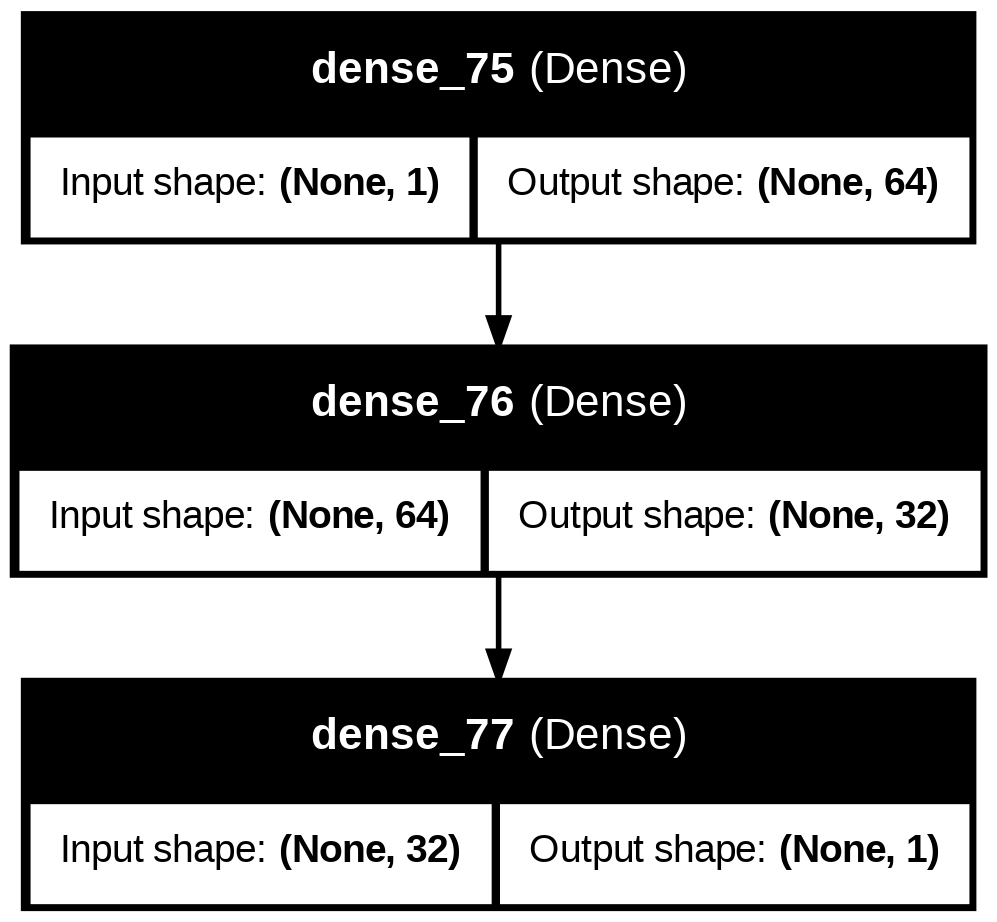

In [128]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Assuming you have your baseline neural network model defined as model_nn_baseline:
model_nn_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Generate and save the model architecture as an image file
plot_model(model_nn_baseline, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [129]:
![Model Architecture](model_architecture.png)


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[Model Architecture](model_architecture.png)'


#Task: Define a function that creates models without and With specified Optimization techniques


In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

def define_model(optimization: str,
                 regularization_datatype,
                 early_stopping: bool,
                 dropout_rate: float,
                 learning_rate: float,
                 input_dim: int):
    """
    Create and compile a Keras Sequential model for binary classification.

    Parameters:
      optimization (str): Specifies the optimizer to use.
                          If 'adam' or 'rmsprop', the optimized model is built.
                          Otherwise (e.g., 'none'), a baseline model without extra techniques is built.
      regularization_datatype: Regularization type to apply ('l1', 'l2', or None).
      early_stopping (bool): Whether to include an EarlyStopping callback.
      dropout_rate (float): Dropout rate (set > 0 to include dropout layers).
      learning_rate (float): Learning rate for the optimizer.
      input_dim (int): The number of input features.

    Returns:
      model: The compiled Keras model.
      callbacks: A list of callbacks (e.g., early stopping) to use during training.
    """
    model = Sequential()

    # Check if we are using optimization techniques (i.e. a valid optimizer is provided)
    if optimization.lower() in ['adam', 'rmsprop']:
        # Set the optimizer with the specified learning rate
        if optimization.lower() == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimization.lower() == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate)

        # Set the regularization method, if provided
        reg = None
        if regularization_datatype is not None:
            if regularization_datatype.lower() == 'l1':
                reg = l1(0.01)
            elif regularization_datatype.lower() == 'l2':
                reg = l2(0.01)

        # Build the optimized model architecture
        model.add(Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation='relu', kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    else:
        # Baseline model without specified optimization techniques
        optimizer = Adam()  # Use default Adam settings
        model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Prepare callbacks list (e.g., early stopping)
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    return model, callbacks

# Example usage:
# Suppose X_train has shape (n_samples, n_features)
# baseline_model, baseline_callbacks = define_model(optimization='none',
#                                                     regularization_datatype=None,
#                                                     early_stopping=False,
#                                                     dropout_rate=0.0,
#                                                     learning_rate=0.001,
#                                                     input_dim=X_train.shape[1])
# optimized_model, optimized_callbacks = define_model(optimization='adam',
#                                                       regularization_datatype='l2',
#                                                       early_stopping=True,
#                                                       dropout_rate=0.5,
#                                                       learning_rate=0.001,
#                                                       input_dim=X_train.shape[1])


# Task: Print out the Final Model Accuracy and plot the Loss curve

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 999ms/step - accuracy: 0.4822 - loss: 0.6637 - val_accuracy: 0.4000 - val_loss: 0.6715
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4613 - loss: 0.6472 - val_accuracy: 0.4000 - val_loss: 0.6623
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4613 - loss: 0.6280 - val_accuracy: 0.4000 - val_loss: 0.6543
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4509 - loss: 0.6186 - val_accuracy: 0.4000 - val_loss: 0.6477
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4509 - loss: 0.6101 - val_accuracy: 0.4000 - val_loss: 0.6426
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4718 - loss: 0.5896 - val_accuracy: 0.4000 - val_loss: 0.6383
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4613 - loss: 0.5852 - val_accuracy: 0.4000 - val_loss: 0.6348
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4405 - loss: 0.5855 - val_accuracy: 0.4000 - val_loss: 0.6318
Epoch 9/5

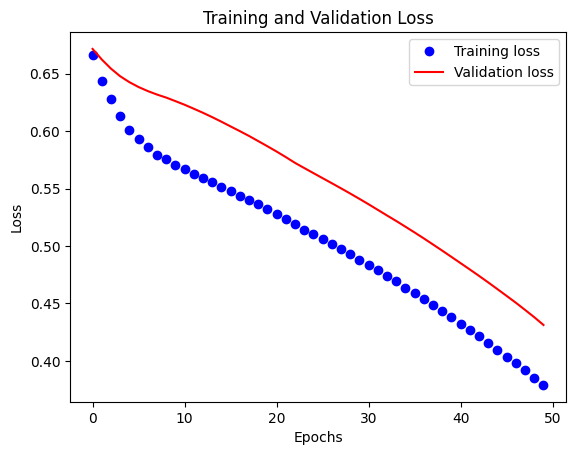

In [131]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the loss curve plotting function (only one plot is needed)
def loss_curve_plot(history): # Changed to take history as input
    plt.plot(history.history['loss'], 'bo', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Define the model and callbacks
model, callbacks = define_model(optimization='adam',  # Assuming 'adam' optimization is desired
                                 regularization_datatype=None,
                                 early_stopping=False,
                                 dropout_rate=0.0,
                                 learning_rate=0.001,
                                 input_dim=X_train.shape[1])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks) # Added model training step

# Evaluate the final model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Final Test Accuracy:", test_accuracy)

# Create a list of epoch numbers (assuming history.history has a key 'loss')
epochs = range(1, len(history.history['loss']) + 1)

# Plot the loss curve using the function
loss_curve_plot(history)  # Changed to pass the history object


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [132]:
def define_model(optimization, regularization_datatype, early_stopping, dropout_rate, learning_rate, input_dim):
    model = Sequential()

    # Define regularization based on input
    reg = None
    if regularization_datatype == 'l1':
        reg = l1(0.01)
    elif regularization_datatype == 'l2':
        reg = l2(0.01)

    # Start with the input dimension
    model.add(Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=reg))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
    model.add(Dense(1, activation='sigmoid'))

    # Configure the optimizer
    if optimization == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimization == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)  # default to Adam if no valid option is provided

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    return model, callbacks

In [133]:
from sklearn.metrics import confusion_matrix, classification_report
!pip install scikit-learn

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.5387 - loss: 0.9576 - val_accuracy: 0.6000 - val_loss: 0.8013
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5178 - loss: 0.8998 - val_accuracy: 0.6000 - val_loss: 0.7759
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5387 - loss: 0.8457 - val_accuracy: 0.6000 - val_loss: 0.7536
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5274 - loss: 0.8052 - val_accuracy: 0.5500 - val_loss: 0.7344
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4831 - loss: 0.7592 - val_accuracy: 0.3000 - val_loss: 0.7180
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2728 - loss: 0.7333 - val_accuracy: 0.3000 - val_loss: 0.7034
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3007 - loss: 0.6998 - val_accuracy: 0.4000 - val_loss: 0.6928
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4613 - loss: 0.6805 - val_accuracy: 0.4000 - val_loss: 0.6839
Epo

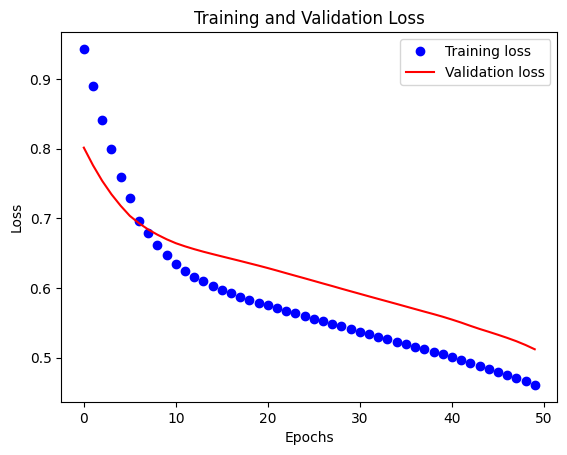

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8500 - loss: 0.4108
Test Accuracy: 0.8500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Confusion Matrix:
[[ 5  3]
 [ 0 12]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.80      1.00      0.89        12

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



In [134]:
# Train the model
model_2, callbacks_2 = define_model(
    optimization='adam',
    regularization_datatype=None,
    early_stopping=True,
    dropout_rate=0.0,
    learning_rate=0.001,
    input_dim=X_train.shape[1]
)

history_2 = model_2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=callbacks_2
)

# Plot the loss curve
loss_curve_plot(history_2)

# Evaluate on the test set
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions on the test set
y_pred_prob = model_2.predict(X_test)

# For binary classification, convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype("int32")

# Alternatively, for multiclass classification, use:
# y_pred = np.argmax(y_pred_prob, axis=1)

# Generate and print the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.5595 - loss: 0.8406 - val_accuracy: 0.5500 - val_loss: 0.7307
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4283 - loss: 0.7520 - val_accuracy: 0.1500 - val_loss: 0.7063
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1520 - loss: 0.7085 - val_accuracy: 0.4000 - val_loss: 0.6914
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4613 - loss: 0.6826 - val_accuracy: 0.4000 - val_loss: 0.6806
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4613 - loss: 0.6626 - val_accuracy: 0.4000 - val_loss: 0.6713
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4613 - loss: 0.6475 - val_accuracy: 0.4000 - val_loss: 0.6630
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4613 - loss: 0.6355 - val_accuracy: 0.4000 - val_loss: 0.6555
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4961 - loss: 0.6284 - val_accuracy: 0.4000 - val_loss: 0.6492
Epo

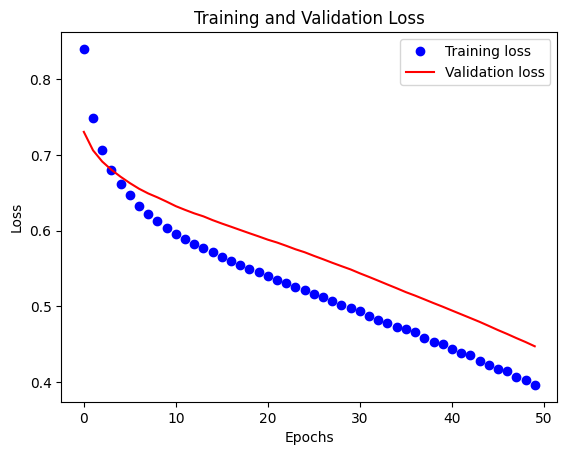

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9500 - loss: 0.3638
Test Accuracy for Model 3: 0.9500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Confusion Matrix for Model 3:
[[ 7  1]
 [ 0 12]]
Classification Report for Model 3:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [135]:
# Define and train Model 3 using RMSprop optimizer
model_3, _ = define_model(
    optimization='rmsprop',              # Correct keyword argument
    regularization_datatype=None,        # Correct keyword argument
    early_stopping=False,                # Include if needed
    dropout_rate=0.0,
    learning_rate=0.001,
    input_dim=X_train.shape[1]
)
history_3 = model_3.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Plot loss curve for Model 3
loss_curve_plot(history_3)

# Evaluate Model 3 on test dataset
test_loss_3, test_accuracy_3 = model_3.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy for Model 3: {test_accuracy_3:.4f}")

# Generate predictions and print confusion matrix and classification report for Model 3
y_pred_3 = (model_3.predict(X_test) > 0.5).astype(int)
cm_3 = confusion_matrix(y_test, y_pred_3)
print("Confusion Matrix for Model 3:")
print(cm_3)
print("Classification Report for Model 3:")
print(classification_report(y_test, y_pred_3))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.5595 - loss: 0.7476 - val_accuracy: 0.6000 - val_loss: 0.7018
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6186 - loss: 0.7076 - val_accuracy: 0.4000 - val_loss: 0.6830
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4718 - loss: 0.6690 - val_accuracy: 0.4000 - val_loss: 0.6681
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4822 - loss: 0.6376 - val_accuracy: 0.4000 - val_loss: 0.6580
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4509 - loss: 0.6247 - val_accuracy: 0.4000 - val_loss: 0.6508
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4718 - loss: 0.6052 - val_accuracy: 0.4000 - val_loss: 0.6457
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4718 - loss: 0.5908 - val_accuracy: 0.4000 - val_loss: 0.6411
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4613 - loss: 0.5864 - val_accuracy: 0.4000 - val_loss: 0.6372

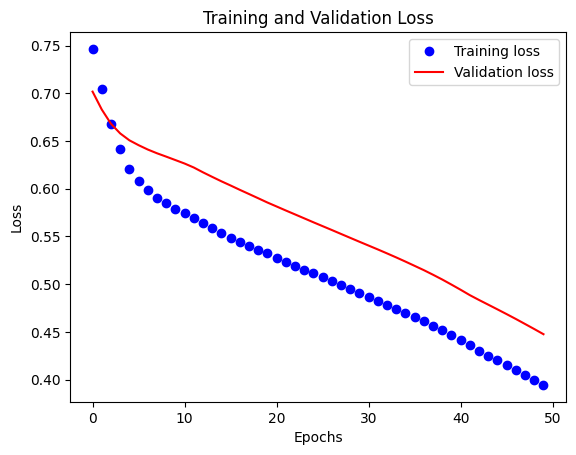

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9500 - loss: 0.3580
Test Accuracy for Model 4: 0.9500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Confusion Matrix for Model 4:
[[ 7  1]
 [ 0 12]]
Classification Report for Model 4:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [136]:
# Define and train Model 4 using default settings (assume Adam if not specified)
model_4, _ = define_model(
    optimization='adam',               # Updated parameter name
    regularization_datatype=None,      # Updated parameter name
    early_stopping=False,              # Specify as needed (or True if you want to use early stopping)
    dropout_rate=0.0,
    learning_rate=0.001,
    input_dim=X_train.shape[1]
)
history_4 = model_4.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Plot loss curve for Model 4
loss_curve_plot(history_4)

# Evaluate Model 4 on test dataset
test_loss_4, test_accuracy_4 = model_4.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy for Model 4: {test_accuracy_4:.4f}")

# Generate predictions and print confusion matrix and classification report for Model 4
y_pred_4 = (model_4.predict(X_test) > 0.5).astype(int)
cm_4 = confusion_matrix(y_test, y_pred_4)
print("Confusion Matrix for Model 4:")
print(cm_4)
print("Classification Report for Model 4:")
print(classification_report(y_test, y_pred_4))


In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# ------------------------------
# Logistic Regression Model Tuning
# ------------------------------

# Define the parameter grid for tuning Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],          # Regularization types: L1 and L2
    'solver': ['liblinear']           # liblinear supports both l1 and l2 penalties
}

# Instantiate a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Setup GridSearchCV: 5-fold cross-validation using accuracy as the scoring metric
grid_lr = GridSearchCV(estimator=log_reg,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1,  # Use all processors for faster computation
                       verbose=1)

# Fit the GridSearchCV object to the training data
grid_lr.fit(X_train, y_train)

# Print out the best parameters and best CV score
print("Best Hyperparameters:", grid_lr.best_params_)
print("Best Cross-Validation Accuracy:", grid_lr.best_score_)

# Evaluate the best model on the test set
y_pred_lr = grid_lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)

print("\nTest Metrics for the Tuned Logistic Regression Model:")
print("Accuracy:", acc_lr)
print("F1 Score:", f1_lr)
print("Precision:", prec_lr)
print("Recall:", rec_lr)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 1.0

Test Metrics for the Tuned Logistic Regression Model:
Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0

Confusion Matrix:
 [[ 8  0]
 [ 0 12]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [138]:
import os
import pickle

# Define the saved model path
model_path = 'saved_models/logistic_model.sav'

# Check if the file exists and load the model
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        loaded_logistic_model = pickle.load(file)

    # Generate predictions on X_test
    predictions_logistic = loaded_logistic_model.predict(X_test)
    print("Predictions from the Loaded Logistic Regression Model:")
    print(predictions_logistic)
else:
    print(f"Model file '{model_path}' does not exist.")

Predictions from the Loaded Logistic Regression Model:
[0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1]


Save models

In [139]:
import os
import pickle

# Create the folder 'saved_models' if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save the neural network baseline model
filename = 'saved_models/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f"Neural Network Baseline Model saved as {filename}")

# Save the optimized neural network model (Instance 2)
filename_2 = 'saved_models/finalized_model_2.sav'
pickle.dump(model_2, open(filename_2, 'wb'))
print(f"Optimized NN Model (Instance 2) saved as {filename_2}")

# Save the optimized neural network model (Instance 3: RMSprop)
filename_3 = 'saved_models/finalized_model_3.sav'
pickle.dump(model_3, open(filename_3, 'wb'))
print(f"Optimized NN Model (Instance 3, RMSprop) saved as {filename_3}")

# Save the optimized neural network model (Instance 4: Adam default)
filename_4 = 'saved_models/finalized_model_4.sav'
pickle.dump(model_4, open(filename_4, 'wb'))
print(f"Optimized NN Model (Instance 4, Adam default) saved as {filename_4}")


filename_logistic = 'saved_models/finalized_logistic_model.sav'
pickle.dump(grid_lr.best_estimator_, open(filename_logistic, 'wb'))
print(f"\nTuned Logistic Regression model saved as {filename_logistic}")


Neural Network Baseline Model saved as saved_models/finalized_model.sav
Optimized NN Model (Instance 2) saved as saved_models/finalized_model_2.sav
Optimized NN Model (Instance 3, RMSprop) saved as saved_models/finalized_model_3.sav
Optimized NN Model (Instance 4, Adam default) saved as saved_models/finalized_model_4.sav

Tuned Logistic Regression model saved as saved_models/finalized_logistic_model.sav


In [140]:
# Import required functions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from IPython.display import display

# ------------------------------
# Compute Predictions and Metrics for NN Models
# ------------------------------

# Instance 1: Baseline model (model)
pred_1 = (model.predict(X_test) > 0.5).astype(int)
acc_1 = accuracy_score(y_test, pred_1)
f1_1 = f1_score(y_test, pred_1)
prec_1 = precision_score(y_test, pred_1)
rec_1 = recall_score(y_test, pred_1)

# Instance 2: Optimized model with Adam and Early Stopping (model_2)
pred_2 = (model_2.predict(X_test) > 0.5).astype(int)
acc_2 = accuracy_score(y_test, pred_2)
f1_2 = f1_score(y_test, pred_2)
prec_2 = precision_score(y_test, pred_2)
rec_2 = recall_score(y_test, pred_2)

# Instance 3: Optimized model with RMSprop (model_3)
pred_3 = (model_3.predict(X_test) > 0.5).astype(int)
acc_3 = accuracy_score(y_test, pred_3)
f1_3 = f1_score(y_test, pred_3)
prec_3 = precision_score(y_test, pred_3)
rec_3 = recall_score(y_test, pred_3)

# Instance 4: Optimized model with default Adam (model_4)
pred_4 = (model_4.predict(X_test) > 0.5).astype(int)
acc_4 = accuracy_score(y_test, pred_4)
f1_4 = f1_score(y_test, pred_4)
prec_4 = precision_score(y_test, pred_4)
rec_4 = recall_score(y_test, pred_4)

# ------------------------------
# Logistic Regression Metrics (Instance 5)
# ------------------------------
# Assuming you have already computed:
# y_pred_lr, acc_lr, f1_lr, prec_lr, rec_lr using GridSearchCV
# For example:
# y_pred_lr = grid_lr.predict(X_test)
# acc_lr = accuracy_score(y_test, y_pred_lr)
# f1_lr = f1_score(y_test, y_pred_lr)
# prec_lr = precision_score(y_test, y_pred_lr)
# rec_lr = recall_score(y_test, y_pred_lr)

# ------------------------------
# Extract tuned logistic regression hyperparameters for inclusion in the table
best_params = grid_lr.best_params_  # e.g., {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

results_data = {
    "Training Instance": ["Instance 1", "Instance 2", "Instance 3", "Instance 4", "Instance 5: Logistic Regression"],
    "Optimizer Used": ["Adam", "Adam", "RMSprop", "Adam", "N/A"],
    "Regularizer Used": ["None", "None", "None", "None", f"{best_params['penalty']} (C={best_params['C']})"],
    "Epochs": [50, 50, 50, 50, "N/A"],
    "Early Stopping": ["No", "Yes", "No", "No", "N/A"],
    "Number of Layers": [3, 3, 3, 3, "N/A"],
    "Learning Rate": [0.001, 0.001, 0.001, 0.001, "N/A"],
    "Accuracy": [acc_1, acc_2, acc_3, acc_4, acc_lr],
    "F1 Score": [f1_1, f1_2, f1_3, f1_4, f1_lr],
    "Recall": [rec_1, rec_2, rec_3, rec_4, rec_lr],
    "Precision": [prec_1, prec_2, prec_3, prec_4, prec_lr]
}

experiment_df = pd.DataFrame(results_data)
from IPython.display import display
display(experiment_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


,Training Instance,Optimizer Used,Regularizer Used,Epochs,Early Stopping,Number of Layers,Learning Rate,Accuracy,F1 Score,Recall,Precision
0,Instance 1,Adam,None,50,No,3,0.001,0.95,0.960000,1.0,0.923077
1,Instance 2,Adam,None,50,Yes,3,0.001,0.85,0.888889,1.0,0.800000
2,Instance 3,RMSprop,None,50,No,3,0.001,0.95,0.960000,1.0,0.923077
3,Instance 4,Adam,None,50,No,3,0.001,0.95,0.960000,1.0,0.923077
4,Instance 5: Logistic Regression,N/A,l2 (C=1),N/A,N/A,N/A,N/A,1.00,1.000000,1.0,1.000000


#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [141]:
# Assume 'model' is the trained model instance
# Save the model in the new native Keras format
model.save('my_model.keras')



In [142]:
def make_predictions(model_path, X):
    from tensorflow.keras.models import load_model

    # Load the model from the specified path
    model = load_model(model_path)

    # Make predictions (this returns probabilities)
    predictions_prob = model.predict(X)

    # Convert probabilities to binary labels (0 or 1)
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions

# Example usage (Ensure X_test is defined and model_path points to a valid model file)
model_path = 'my_model.keras'  # Changed to 'my_model.keras' to match the saved model filename
predictions = make_predictions(model_path, X_test)

# Print the predictions to see the output
print("Predictions from the best model:")
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predictions from the best model:
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]]


Congratulations!!
